In [ ]:
! pip install -q condacolab

In [ ]:
import condacolab
condacolab.install()

In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
! pip install PyTDC

In [ ]:
! mamba install -c conda-forge rdkit

In [ ]:
from tdc.multi_pred import DTI
kiba = DTI(name='KIBA')
kiba.convert_to_log(form = 'binding')
# convert back: data.convert_from_log(form = 'binding')

In [ ]:
kiba.get_data()

,Drug_ID,Drug,Target_ID,Target,Y
0,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O00141,MTVKTEAAKGTLTYSRMRGMVAILIAFMKQRRMGLNDFIQKIANNS...,7.950782
1,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O14920,MSWSPSLTTQTCGAWEMKERLGTGGFGNVIRWHNQETGEQIAIKQC...,7.950782
2,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,O15111,MERPPGLRPGAGGPWEMRERLGTGGFGNVCLYQHRELDLKIAIKSC...,7.950782
3,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P00533,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,7.950782
4,CHEMBL1087421,COc1cc2c(cc1Cl)C(c1ccc(Cl)c(Cl)c1)=NCC2,P04626,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,7.950782
...,...,...,...,...,...
118031,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13554,MATTVTCTRFTDEYQLYEDIGKGAFSVVRRCVKLCTGHEYAAKIIN...,7.974779
118032,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13555,MATTATCTRFTDDYQLFEELGKGAFSVVRRCVKKTSTQEYAAKIIN...,7.974779
118033,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q13557,MASTTTCTRFTDEYQLFEELGKGAFSVVRRCMKIPTGQEYAAKIIN...,7.974779
118034,CHEMBL230654,CCCc1nc[nH]c1CNc1cc(Cl)c2ncc(C#N)c(Nc3ccc(F)c(...,Q16539,MSQERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKT...,7.974779


In [ ]:
split = kiba.get_split(method = 'random', seed = 42, frac = [0.8, 0.1, 0.1])

In [ ]:
train = split['train']
valid = split['valid']
test = split['test']

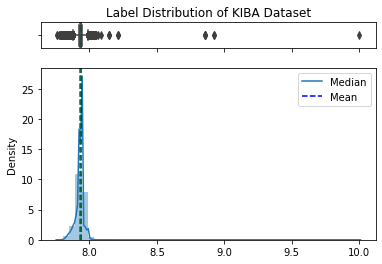

In [ ]:
kiba.label_distribution()

In [ ]:
! pip install bio-embeddings[all] --ignore-installed

In [ ]:
! pip install tqdm==4.41.1

In [ ]:
! pip install dgllife

In [ ]:
! pip install dgl-cu101

In [ ]:
import dgllife
from dgllife import data
import dgl

In [ ]:
import numpy as np
# from bio_embeddings.embed import ProtTransBertBFDEmbedder

In [ ]:
import pandas as pd
import time

In [ ]:
import networkx as nx

In [ ]:
from collections import defaultdict
# from dgl import backend as F
from rdkit import Chem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig

In [ ]:
from dgllife.data import MoleculeCSVDataset
from dgllife.utils import Meter, smiles_to_bigraph, CanonicalAtomFeaturizer, EarlyStopping, CanonicalBondFeaturizer, BaseAtomFeaturizer, ConcatFeaturizer
from dgllife.utils import BaseAtomFeaturizer, atom_type_one_hot, atom_degree_one_hot, \
    atom_formal_charge, atom_num_radical_electrons, \
    atom_hybridization_one_hot, atom_total_num_H_one_hot, atom_implicit_valence_one_hot, atom_is_aromatic, atom_is_chiral_center, atom_chirality_type_one_hot
from dgllife.utils.featurizers import BaseBondFeaturizer
from dgl.data.utils import save_graphs, load_graphs
from dgllife.model import AttentiveFPPredictor
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
from functools import partial

In [ ]:
import shutil
import torch
import torch.nn as nn

from copy import deepcopy
from hyperopt import fmin, tpe
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
kiba = kiba.get_data()
sequences = kiba['Target'].unique()

In [ ]:
#number of unique sequences 
len(sequences)

229

In [ ]:
embedder = ProtTransBertBFDEmbedder()

In [ ]:
embeddings = [embedder.reduce_per_protein(embedder.embed(seq)) for seq in sequences]

In [ ]:
embeddings[1].shape

In [ ]:
# convert to tensor
embeddings = [torch.tensor(e) for e in embeddings]

In [ ]:
# add passing to make the sequences of the same length
padded_embeddings = pad_sequence(embeddings, batch_first=True)

In [ ]:
print(padded_embeddings.shape)
# padded_embeddings = padded_embeddings.permute(1, 0, 2)
# print(padded_embeddings.shape)

In [ ]:
padded_embeddings = padded_embeddings.tolist()

In [ ]:
embeddings = pd.DataFrame(list(zip(sequences, padded_embeddings)),
              columns=['Target','embedding'])

In [ ]:
embeddings.to_csv('kiba_protransbert_1024.csv')

In [ ]:
embeddings = pd.read_csv('kiba_protransbert_1024.csv', converters={'embedding': eval})

In [ ]:
train = pd.merge(train, embeddings, on='Target', how='outer')
train = train.dropna()

valid = pd.merge(valid, embeddings, on='Target', how='outer')
valid = valid.dropna()

test = pd.merge(test, embeddings, on='Target', how='outer')
test = test.dropna()

In [ ]:
node_featurizer =  BaseAtomFeaturizer(
        featurizer_funcs={'hv': ConcatFeaturizer([
            partial(atom_type_one_hot, allowable_set=[
                'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
                    encode_unknown=True),
            partial(atom_degree_one_hot, allowable_set=list(range(6))),
            atom_formal_charge, atom_num_radical_electrons,
            partial(atom_hybridization_one_hot, encode_unknown=True),
            lambda atom: [0], # A placeholder for aromatic information,
            atom_total_num_H_one_hot, atom_is_chiral_center, atom_chirality_type_one_hot
        ],
        )})

In [ ]:
edge_featurizer = BaseBondFeaturizer({'he': lambda bond: [0 for _ in range(10)]})

In [ ]:
class GraphWithProtein(MoleculeCSVDataset):
    def __init__(self,
                 df,
                 smiles_to_graph=smiles_to_bigraph,
                 node_featurizer=None,
                 edge_featurizer=None,
                 smiles_column='Drug',
                 cache_file_path='protein_dglgraph.bin',
                 task_names=['Target'],
                 load=True,
                 log_every=1000):

        self.protein = torch.tensor(df['embedding'].tolist()).float()
        self.load_full = True

        super(GraphWithProtein, self).__init__(df=df,
                                            smiles_to_graph=smiles_to_graph,
                                            node_featurizer=node_featurizer,
                                            edge_featurizer=edge_featurizer,
                                            smiles_column=smiles_column,
                                            cache_file_path=cache_file_path,
                                            task_names=task_names,
                                            load=load,
                                            log_every=log_every)

    def __getitem__(self, item):
        if self.load_full:
            return self.smiles[item], self.graphs[item], self.labels[item], self.protein[item]
        else:
            return self.smiles[item], self.graphs[item], self.labels[item]

In [ ]:
train_set = GraphWithProtein(df=train, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='dglgraph1.bin', smiles_column='Drug', task_names=['Y'], log_every=1000)
val_set = GraphWithProtein(df=valid, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='dglgraph2.bin', smiles_column='Drug', task_names=['Y'], log_every=1000)
test_set = GraphWithProtein(df=test, smiles_to_graph=smiles_to_bigraph, node_featurizer=node_featurizer, edge_featurizer=edge_featurizer, cache_file_path='dglgraph3.bin', smiles_column='Drug', task_names=['Y'], log_every=1000)

In [ ]:
graph_feat_size = 100
num_layers = 2
num_timesteps = 2
node_feat_size = 39
edge_feat_size = 10
n_tasks = 1
dropout = 0.2
weight_decay = 10 ** (-5.0)
lr = 10 ** (-3)
batch_size = 64
num_epochs = 800
mode = 'lower'
patience = 20

In [ ]:
def collate_molgraphs(data):
    masks = None
    smiles, graphs, labels, protein = map(list, zip(*data))

    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
    protein = torch.stack(protein, dim=0)

    if masks is None:
        masks = torch.ones(labels.shape)
    else:
        masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, protein, masks
#     return smiles, bg, labels, masks

In [ ]:
def regress(model, bg, protein):
    bg = bg.to(device)
    atom_feats, bond_feats = bg.ndata.pop('hv'), bg.edata.pop('he')
    atom_feats, bond_feats = atom_feats.to(device), bond_feats.to(device)
    return model(bg, protein, atom_feats, bond_feats)
    
def run_a_train_epoch(epoch, model, data_loader,
                      loss_criterion, optimizer):
    model.train()
    train_meter_mae = Meter()
    train_meter_mse = Meter()
    for batch_id, batch_data in enumerate(data_loader):
        smiles, bg, labels, protein, masks = batch_data
        protein = protein.to(device)
        labels, masks = labels.to(device), masks.to(device)
        prediction = regress(model, bg, protein)
        loss = (loss_criterion(prediction, labels) * (masks != 0).float()).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_meter_mae.update(prediction, labels, masks)
        train_meter_mse.update(prediction, labels, masks)
    total_score_mae = np.mean(train_meter_mae.compute_metric('mae'))
    total_score_mse = np.mean(train_meter_mse.compute_metric('rmse'))
    print('epoch {:d}, training {} {:.4f}, training {} {:.4f}'.format(
        epoch + 1,  'mae', total_score_mae, 'mse', total_score_mse**2))

def run_an_eval_epoch(model, data_loader):
    model.eval()
    eval_meter_mae = Meter()
    eval_meter_mse = Meter()
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, protein, masks = batch_data
            protein = protein.to(device)
            labels = labels.to(device)
            prediction = regress(model, bg, protein)
            eval_meter_mae.update(prediction, labels, masks)
            eval_meter_mse.update(prediction, labels, masks)
        total_score_mae = np.mean(eval_meter_mae.compute_metric('mae'))
        total_score_mse = np.mean(eval_meter_mse.compute_metric('rmse'))
    return total_score_mae, total_score_mse**2

In [ ]:
def set_random_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [ ]:
seed = 42
set_random_seed(seed)

In [ ]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size,
                          shuffle=True, collate_fn=collate_molgraphs)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_molgraphs)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_molgraphs)

In [ ]:
class AttentiveFPPredictor(nn.Module):

    def __init__(self,
                 node_feat_size,
                 edge_feat_size,
                 pr_input_size=1024,
                 pr_out_size=64,
                 num_layers=2,
                 num_timesteps=2,
                 graph_feat_size=100,
                 n_tasks=100,
                 dropout=0.):
        super(AttentiveFPPredictor, self).__init__()
        
        self.layer1 = nn.Linear(pr_input_size, 128)
        self.layer2 = nn.Linear(128, pr_out_size)
        self.layer3 = nn.Linear(n_tasks + pr_out_size, 64)
        self.layer4 = nn.Linear(64, 1)
        
        self.gnn = AttentiveFPGNN(node_feat_size=node_feat_size,
                                  edge_feat_size=edge_feat_size,
                                  num_layers=num_layers,
                                  graph_feat_size=graph_feat_size,
                                  dropout=dropout)
        self.readout = AttentiveFPReadout(feat_size=graph_feat_size,
                                          num_timesteps=num_timesteps,
                                          dropout=dropout)
        self.predict = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(graph_feat_size, n_tasks)
        )
        

    def forward(self, g, fp, node_feats, edge_feats, get_node_weight=False):

        x1 = F.relu(self.layer1(fp))
        x1 = F.relu(self.layer2(x1))
        
        node_feats = self.gnn(g, node_feats, edge_feats)
        g_feats = self.readout(g, node_feats, get_node_weight)
        x2 = self.predict(g_feats)
        
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.layer3(x))
        x = self.layer4(x)
        
        return x

In [ ]:
model = AttentiveFPPredictor(node_feat_size=39,
                              edge_feat_size=10,
                              num_layers=num_layers,
                              num_timesteps=num_timesteps,
                              graph_feat_size=graph_feat_size,
                              n_tasks=n_tasks,
                              dropout=dropout)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
loss_fn = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
stopper = EarlyStopping(mode=mode, patience=patience)
model.to(device)

In [ ]:
for epoch in range(num_epochs):
    # Train
    train_start = time.time()
    run_a_train_epoch(epoch, model, train_loader, loss_fn, optimizer)
    train_time = time.time() - train_start
    # Validation and early stop
    val_start = time.time()
    val_score_mae, val_score_mse = run_an_eval_epoch(model, val_loader)
    val_time = time.time() - val_start
    early_stop = stopper.step(val_score_mse, model)
    print('epoch {:d}/{:d}, validation {} {:.4f}, validation {} {:.4f}, best validation {} {:.4f}, train epoch time {}, validation epoch time {}'.format(
        epoch + 1, num_epochs, 'mae', val_score_mae, 'mse', val_score_mse,
        'mae', stopper.best_score, train_time, val_time))
    if early_stop:
      print('\nLoading the saved model')
      stopper.load_checkpoint(model)
      break

In [ ]:
def save_checkpoint(model, path):
  torch.save({'model_state_dict': model.state_dict()}, path + '.pth')

In [ ]:
 save_checkpoint(model, 'Kiba_ProTransBert_allfeatures')

In [ ]:
# checkpoint = torch.load('Kiba_ProTransBert.pth')
checkpoint = torch.load('Kiba_ProTransBert.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    eval_meter_mae = Meter()
    eval_meter_mse = Meter()
    predictions = []
    originals = []
    with torch.no_grad():
        for batch_id, batch_data in enumerate(data_loader):
            smiles, bg, labels, protein, masks = batch_data
            protein = protein.to(device)
            originals.append(labels)
            labels = labels.to(device)
            prediction = regress(model, bg, protein)
            predictions.append(prediction)
            eval_meter_mae.update(prediction, labels, masks)
            eval_meter_mse.update(prediction, labels, masks)
        total_score_mae = np.mean(eval_meter_mae.compute_metric('mae'))
        total_score_mse = np.mean(eval_meter_mse.compute_metric('rmse'))
    originals = torch.cat(originals, dim=0).squeeze().tolist()
    predictions = torch.cat(predictions, dim=0).squeeze().tolist()
    return total_score_mae, total_score_mse**2, originals, predictions

In [ ]:
def run_eval_on_data(model, data):
  test_loader = DataLoader(dataset=data, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_molgraphs)
  mae, mse, originals, predictions = run_an_eval_epoch(model, test_loader)
  originals = torch.cat(originals, dim=0).squeeze().tolist()
  predictions = torch.cat(predictions, dim=0).squeeze().tolist()
  return mae, mse, originals, predictions

In [ ]:
mae, mse, labels, preds = evaluate_model(model, test_loader)

In [ ]:
from tdc import Evaluator

In [ ]:
! pip install lifelines

In [ ]:
from lifelines.utils import concordance_index

In [ ]:
tdc_mse = Evaluator(name = 'MSE')
tdc_rmse = Evaluator(name = 'RMSE')
tdc_r2 = Evaluator(name = 'R2')
tdc_pcc = Evaluator(name = 'PCC')
tdc_sp = Evaluator(name = 'Spearman')

In [ ]:
print('mse: ', tdc_mse(labels, preds), 'rmse: ', tdc_rmse(labels, preds), 'r2: ', tdc_r2(labels, preds), 'pcc: ', tdc_pcc(labels, preds), 'spearman: ', tdc_sp(labels, preds), 'CI: ', concordance_index(labels, preds))

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.rcParams.update({'figure.figsize':(16,8), 'figure.dpi':200})
plt.scatter(preds, labels, c=preds, cmap='Spectral')
plt.colorbar()
plt.xlim(8, 17)
plt.ylim(8, 17)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
plot = sns.jointplot(x=preds, y=labels, kind='reg', height=5, ratio=4, marginal_kws=dict(bins=25, fill=False))
plot.ax_marg_x.set_xlim(8, 17)
plot.ax_marg_y.set_ylim(8, 17)

plt.show()